# 2.12 効用関数の同定

In [2]:
# ライブラリ
import numpy as np
import pandas as pd
pd.set_option("display.unicode.east_asian_width", True)
pd.set_option("display.precision", 3)
from scipy import interpolate
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
!pip install japanize-matplotlib
import japanize_matplotlib
japanize_matplotlib.japanize()

     |████████████████████████████████| 4.1 MB 31.1 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120275 sha256=d35617c8273b40adfb0a2860637e7c975f508e2e3c574228239d30742b7a93c9
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib


In [4]:
# 確実同値額と効用
cme = np.array([0, 5, 20, 50, 100])
utility = np.array([0, 0.25, 0.5, 0.75, 1])

In [5]:
# 金額を入力すると線形補間された効用が出力される関数
u_func = interpolate.interp1d(cme, utility)

# 0から100まで1区切りで効用を計算
money = np.arange(0, 101, 1)
interpolated_utility = u_func(money)

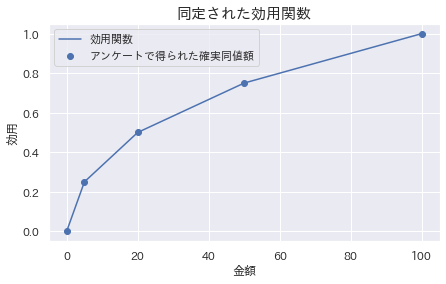

In [8]:
# 可視化
fig, ax = plt.subplots(figsize = (7, 4))
ax.plot(money, interpolated_utility, label = "効用関数")
ax.scatter(cme, utility, label = "アンケートで得られた確実同値額")
ax.set_title("同定された効用関数", fontsize = 15)
ax.set_xlabel("金額")
ax.set_ylabel("効用")
ax.legend(loc = "best")

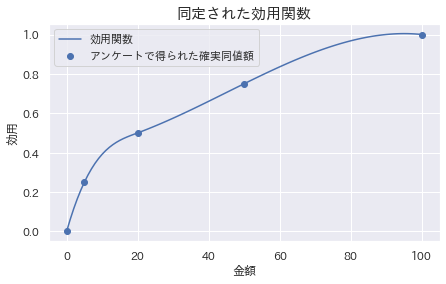

In [12]:
# スプライン補完
u_func_sp = interpolate.interp1d(cme, utility, kind = "cubic") # 3次補間
interpolated_utility_sp = u_func_sp(money)

# 可視化
fig, ax = plt.subplots(figsize = (7, 4))
ax.plot(money, interpolated_utility_sp, label = "効用関数")
ax.scatter(cme, utility, label = "アンケートで得られた確実同値額")
ax.set_title("同定された効用関数", fontsize = 15)
ax.set_xlabel("金額")
ax.set_ylabel("効用")
ax.legend(loc = "best")

# 2.14 期待効用最大化原理に基づく意思決定の手続き

In [13]:
# 最大値をとるインデックスを取得する関数
def argmax_list(series):
  return list(series[series == series.max()].index)

In [14]:
# 期待値最大化に基づく意思決定を行う関数
def max_emv(probs, payoff_table):
  emv = payoff_table.mul(probs, axis = 0).sum()
  max_emv = emv.max()
  a_star = argmax_list(emv)
  return pd.Series([a_star, max_emv], index = ["選択肢", "期待値"])

In [15]:
# 金額で見積もられた利得行列
payoff = pd.DataFrame({
    "対策なし": [100, 0], 
    "対策あり": [50, 50]
})
payoff.index = ["問題なし", "問題あり"]
payoff

,対策なし,対策あり
問題なし,100,50
問題あり,0,50


In [16]:
# 自然の状態と予測値の同時分布
joint_forecast_state = pd.DataFrame({
    "予測－問題なし": [0.4, 0.1], 
    "予測－問題あり": [0.05, 0.45]
})
joint_forecast_state.index = ["問題なし", "問題あり"]
joint_forecast_state

,予測－問題なし,予測－問題あり
問題なし,0.4,0.05
問題あり,0.1,0.45


In [17]:
# 予測値の周辺分布
marginal_forecast = joint_forecast_state.sum(axis = 0)
marginal_forecast

予測－問題なし    0.5
予測－問題あり    0.5
dtype: float64

In [18]:
# 予測が得られたという条件付き分布
conditional_forecast = joint_forecast_state.div(marginal_forecast, axis = 1)
conditional_forecast

,予測－問題なし,予測－問題あり
問題なし,0.8,0.1
問題あり,0.2,0.9


In [19]:
# 条件付き期待金額を最大にする行動
info_decision = conditional_forecast.apply(max_emv, axis = 0, payoff_table = payoff)
info_decision

,予測－問題なし,予測－問題あり
選択肢,[対策なし],[対策あり]
期待値,80.0,50.0


In [21]:
# 予測の周辺分布で期待値を取ると，予測を用いた場合の期待金額を得る
emv_forecast = info_decision.loc["期待値"].mul(marginal_forecast).sum()
print(f"情報を使ったときの期待金額：{emv_forecast:.3g}万円")

情報を使ったときの期待金額：65万円


In [22]:
# 効用で見積もられた利得行列
payoff_u = payoff.apply(u_func)
payoff_u

,対策なし,対策あり
問題なし,1.0,0.75
問題あり,0.0,0.75


In [23]:
# 期待効用を最大化する行動
info_decision_u = conditional_forecast.apply(max_emv, axis = 0, payoff_table = payoff_u)
info_decision_u

,予測－問題なし,予測－問題あり
選択肢,[対策なし],[対策あり]
期待値,0.8,0.75


In [25]:
# 予測の周辺分布で期待値を取ると，予測を用いた場合の期待効用を得る
u_forecast = info_decision_u.loc["期待値"].mul(marginal_forecast).sum()
print(f"情報を使ったときの期待効用：{u_forecast:.3g}")

情報を使ったときの期待効用：0.775
